<a href="https://colab.research.google.com/github/Ignas12345/Project_in_Computational_Biology/blob/main/Combined_notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook unifies the prievious notebooks into a single notebook.**

In [1]:
"""
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/Nikronic/EdgeNet.git
!git clone https://github.com/Ignas12345/Project_in_Computational_Biology.git

Cloning into 'EdgeNet'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 127 (delta 2), reused 4 (delta 1), pack-reused 121
Receiving objects: 100% (127/127), 808.96 KiB | 2.63 MiB/s, done.
Resolving deltas: 100% (72/72), done.
Cloning into 'Project_in_Computational_Biology'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 132 (delta 18), reused 0 (delta 0), pack-reused 78
Receiving objects: 100% (132/132), 17.52 MiB | 19.73 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [2]:
import os
os.makedirs('DIP_images') #This folder will store images before the edge regularization
os.makedirs('Edge_maps') #This folder will store images of the edge map(/-s)
os.makedirs('Images_with_regularization') #This will store the images that we get after applying the edge map regularization

# Import libs

In [3]:
from Project_in_Computational_Biology.models import *
from PIL import Image
from Project_in_Computational_Biology.plotting import plot
from Project_in_Computational_Biology.converters import turn_to_grayscale, image_to_tensor, tensor_to_image, generate_noise

import torch
import torch.optim
from Project_in_Computational_Biology.models.downsampler import Downsampler
from EdgeNet.EdgeNet import EdgeNet

from Project_in_Computational_Biology.utils.sr_utils import *

#comment the following three lines if running on CPU

#torch.backends.cudnn.enabled = True
#torch.backends.cudnn.benchmark =True
#dtype = torch.cuda.FloatTensor

#and uncomment this line
dtype = torch.FloatTensor

upscaling_factor = 8

# Load image

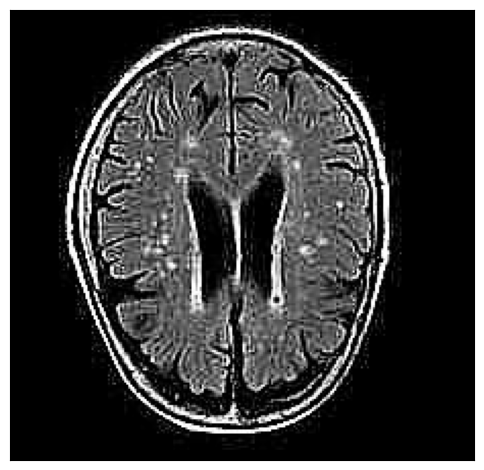

In [4]:
# Starts here
orig_img = Image.open('Project_in_Computational_Biology/pictures/Low_resolution_MRI.jpg')
plot([orig_img], cmap='gray')

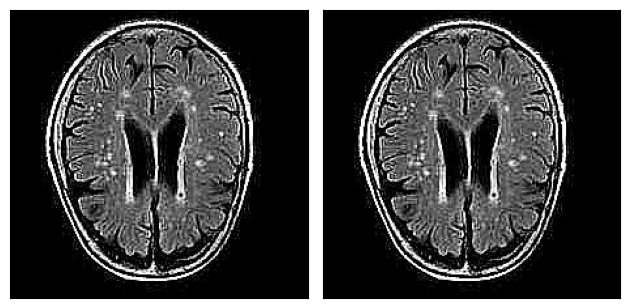

In [5]:
gray_img = turn_to_grayscale(orig_img)
plot([orig_img, gray_img], cmap='gray') #Since both are exactly the same, we will use the grayscale version for speed and less complexity

# Set up parameters and net

In [6]:
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0
edge_regularization_weight = 0.5

OPTIMIZER = 'adam'

num_iter = 1000
reg_noise_std = 0.05

In [7]:
net_image = generate_noise(gray_img, upscaling_factor)

In [8]:
net_input = image_to_tensor(net_image).type(dtype).detach()

In [9]:
NET_TYPE = 'skip' # UNet, ResNet
net = skip(
        num_input_channels=1, num_output_channels=1,
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True,
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU',
        need1x1_up=True).type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = image_to_tensor(gray_img).type(dtype)

downsampler = Downsampler(n_planes=1, factor=upscaling_factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

In [10]:
def closure():
    global i, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var)
    total_loss.backward()
    print('iteration: ' + str(i))

    if i % 25 == 0:
      output_img = tensor_to_image(out_HR)
      plot([gray_img, output_img], cmap = 'gray')
      output_img.save('DIP_images/High_resolution_iteration_' + str(i) + '.jpg')

    i += 1

    return total_loss

Starting optimization with ADAM
iteration: 0


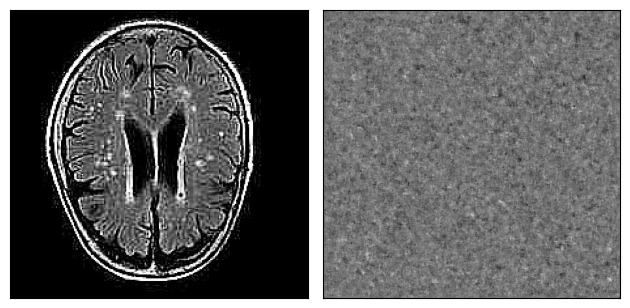

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25


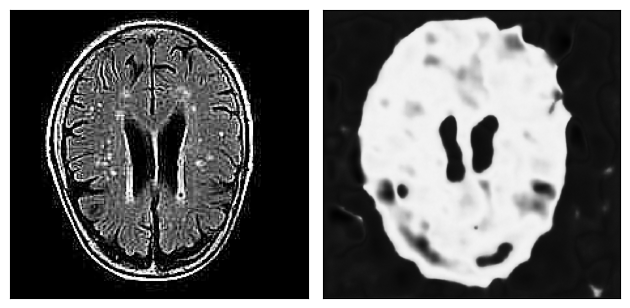

iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41


In [ ]:
psnr_history = []
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

# Now get the edge map

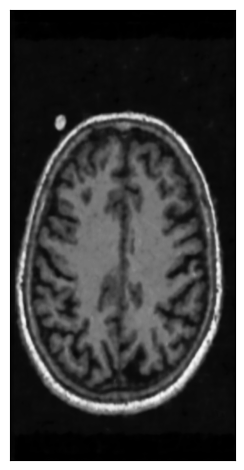

In [19]:
image_we_want_to_use = 400 #must be the number of the iteration that we consider not to have overfitted,  as we will drag back to it
underfitted_img = Image.open('DIP_images/High_resolution_iteration' + str(image_we_want_to_use) + '.jpg')
plot([underfitted_img], cmap='gray')

In [25]:
edgenet = EdgeNet(input_channels = 1).type(dtype)
#Here you can choose which parameters of EdgeNet You want to use. Each can give different results. It becomes like a sort of game at this point...
edgenet.load_state_dict(torch.load('Project_in_Computational_Biology/EdgeNet_parameters/model_parameters_3'))

<All keys matched successfully>

In [26]:
underfitted_edges = edgenet(image_to_tensor(underfitted_img).type(dtype))
underfitted_edges_img = tensor_to_image(underfitted_edges)
plot([underfitted_img, underfitted_edges_img], cmap = 'gray')

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.17 GiB. GPU 0 has a total capacity of 14.75 GiB of which 197.06 MiB is free. Process 8510 has 14.55 GiB memory in use. Of the allocated memory 14.36 GiB is allocated by PyTorch, and 62.34 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
underfitted_edges_img.save('Edge_maps/underfitted_edges.jpg')

# Now apply the edge map Regularization

In [ ]:
def closure_with_edges():
    global i, net_input, edge_regularization_weight

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)
    edges = edgenet(out_HR)

    total_loss = mse(out_LR, img_LR_var)  + edge_regularization_weight * mse(edges, underfitted_edges)
    total_loss.backward()
    print('iteration: ' + str(i))

    if i % 25 == 0:
      output_img = tensor_to_image(out_HR)
      plot([gray_img, output_img], cmap = 'gray')
      output_img.save('Images_with_regularization/High_resolution_iteration_after_edges' + str(i) + '.jpg')

    i += 1

    return total_loss